In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [2]:
import pickle as pk
import numpy as np
import pandas as pd
from phys.phys_utils import nnan_pearsonr as nnan_pearsonr

# import phys.dataset_augment_utils as dataset_augment_utils
# import phys.data_utils as phys_data_utils
# import phys.phys_utils as phys_utils
import utils.dataset_augment_utils as dataset_augment_utils
import utils.data_utils as phys_data_utils
import utils.phys_utils as phys_utils

# from rnn_analysis import utils as analysis_utils
from scipy.stats import rankdata

In [3]:
data = phys_data_utils.load_neural_dataset(timebinsize=50, subject_id='all_hand_dmfc', recompute_augment=True)
data_aug = dataset_augment_utils.augment_data_structure(data)

In [4]:
def make_axis_nice(ax, offset=5):
    sns.despine(ax=ax, offset=offset)
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    return

def smooth(x, win=4, sd=1):
    # typically 50ms sd, 200ms span, but here working on 50ms binned data.
    from scipy import signal
    filt = signal.gaussian(win, std=sd)
    filt = filt / np.nansum(filt)
    return np.convolve(x, filt, 'same') 

def smooth_mat(x, win=4, sd=1):
    x2 = np.ones(x.shape) * np.nan
    for i in range(x2.shape[0]):
        x2[i,:] = smooth(x[i,:], win=win, sd=sd)
    return x2

def midrange(x):
    return (x - np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

def plot_lines_with_color(x, cols, smooth=False, axes=None):
    if smooth:
        x = smooth_mat(x)
    ylimits = [np.nanmin(x)*0.95, np.nanmax(x)*1.1]
    if axes is None:
        f,axes = plt.subplots(1, 1, figsize=(4,3))
        for tr_i in range(x.shape[0]):
            axes.plot(x[tr_i,:], color=cols[tr_i], alpha=0.5)
        axes.set_ylim(ylimits)
        axes.set_yticks([])
        axes.set_xticklabels([])
        sns.despine(ax=axes, offset=5)
            
    plt.tight_layout()
    return
#     f.savefig('%s/path_%s_%d.pdf' % (figsavepath, condition, nidx))

all_cols = {}
for colorvar in ['x0', 'y0', 'n_bounce_correct', 'yf',
                 'dx', 'dy', 'speed0', 'heading0',
                 'paddle_error', 'paddle_error_signed']:
    cax = midrange(rankdata(data_aug['meta'][colorvar]))
    all_cols[colorvar] = plt.cm.plasma(cax)

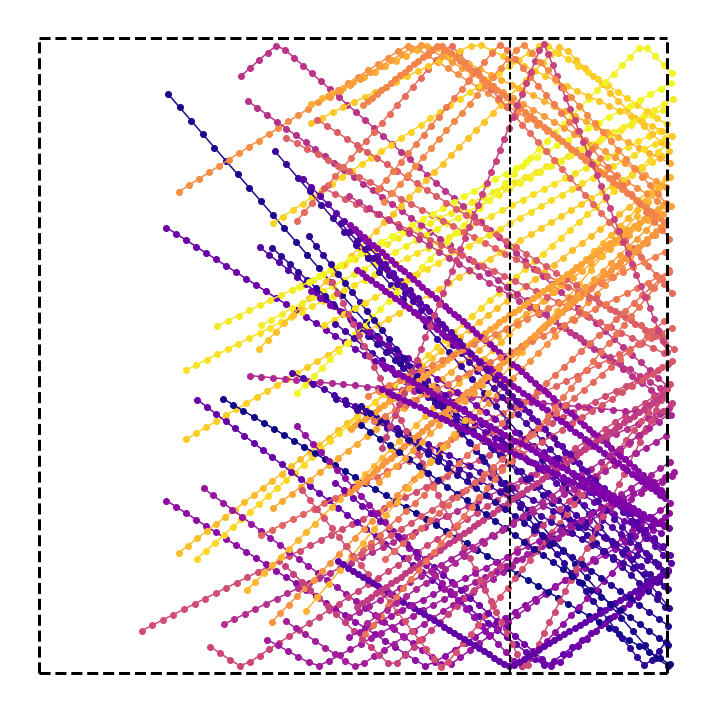

In [5]:
xfn, yfn = 'ball_pos_x_TRUE', 'ball_pos_y_TRUE'
condition = 'occ'
mask_fn = 'start_end_pad0'

x, y = data_aug['behavioral_responses'][condition][xfn], data_aug['behavioral_responses'][condition][yfn]
m = data_aug['masks'][condition][mask_fn]

xm = phys_utils.apply_mask(x,m)
ym = phys_utils.apply_mask(y,m)

f,axes = plt.subplots(1,1,figsize=(10,10))
for xi in range(xm.shape[0]):
    axes.plot(xm[xi,:], ym[xi,:], '-o', color=all_cols['yf'][xi])
axes.plot([-10, 10], [10,10], 'k--', lw=3)
axes.plot([-10, 10], [-10,-10], 'k--', lw=3)
axes.plot([-10, -10], [-10,10], 'k--', lw=3)
axes.plot([10, 10], [-10,10], 'k--', lw=3)
axes.plot([5, 5], [-10,10], 'k--', lw=2)
plt.axis('off')
plt.tight_layout()
# f.savefig('%s/summary_of_conditions_framed.pdf' % figoutpath)

In [11]:
np.savetxt('xm.csv',xm, fmt='%5.3f', delimiter=',', newline='\n')
np.savetxt('ym.csv',ym, fmt='%5.3f', delimiter=',', newline='\n')
print(xm)
print(ym)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [6]:
for mask in ['start_end_pad0', 'start_occ_pad0', 'occ_end_pad0']:
    timebin = 50
    num_bins = [np.nansum(np.isfinite(x))*timebin for x in data_aug['masks']['occ'][mask]]
    print(mask, '%.2f'%np.nanmean(num_bins))
    
    ## currently overlapping by 1 bin


start_end_pad0 2216.46
start_occ_pad0 1291.14
occ_end_pad0 975.32
